<a href="https://colab.research.google.com/github/Matrixmax/Dive_into_DeepLearning/blob/main/0x43_%E5%B0%8F%E6%89%B9%E9%87%8F%E9%9A%8F%E6%9C%BA%E6%A2%AF%E5%BA%A6%E4%B8%8B%E9%99%8D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

在每一次迭代中，梯度下降使用整个训练数据集来计算梯度，因此它有时也被称为批量梯度下降（batch gradient descent）。而随机梯度下降在每次迭代中只随机采样一个样本来计算梯度。正如我们在前几章中所看到的，我们还可以在每轮迭代中随机均匀采样多个样本来组成一个小批量，然后使用这个小批量来计算梯度。

## 1.读取数据

In [1]:
%matplotlib inline
import numpy as np
import time
import torch
from torch import nn, optim
import sys


from google.colab import drive
drive.mount('/content/drive')
sys.path.append('/content/drive/My Drive/Colab Notebooks/Dive_Into_Deep_Learning/')
import d2lzh_pytorch as d2l
from mpl_toolkits import mplot3d # 三维画图
import numpy as np


def get_data_ch7():  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    data = np.genfromtxt('/content/drive/MyDrive/Colab Notebooks/Dive_Into_Deep_Learning/data/airfoil_self_noise.dat', delimiter='\t')
    data = (data - data.mean(axis=0)) / data.std(axis=0)
    return torch.tensor(data[:1500, :-1], dtype=torch.float32), \
    torch.tensor(data[:1500, -1], dtype=torch.float32) # 前1500个样本(每个样本5个特征)

features, labels = get_data_ch7()
features.shape # torch.Size([1500, 5])


Mounted at /content/drive


torch.Size([1500, 5])

## 1. 从零开始实现

3.2节（线性回归的从零开始实现）中已经实现过小批量随机梯度下降算法。我们在这里将它的输入参数变得更加通用，主要是为了方便本章后面介绍的其他优化算法也可以使用同样的输入。具体来说，我们添加了一个状态输入states并将超参数放在字典hyperparams里。此外，我们将在训练函数里对各个小批量样本的损失求平均，因此优化算法里的梯度不需要除以批量大小。

In [2]:
def sgd(params,states,hyperparams):
    for p in params:
        p.data -= hyperparams['lr']*p.grad.data

下面实现一个通用的训练函数，以方便本章后面介绍的其他优化算法使用。它初始化一个线性回归模型，然后可以使用小批量随机梯度下降以及后续小节介绍的其他算法来训练模型。

In [3]:
# 本函数已保存在d2lzh_pytorch包中方便以后使用
def train_ch7(optimizer_fn, states, hyperparams, features, labels,
              batch_size=10, num_epochs=2):
    # 初始化模型
    net, loss = d2l.linreg, d2l.squared_loss

    w = torch.nn.Parameter(torch.tensor(np.random.normal(0, 0.01, size=(features.shape[1], 1)), dtype=torch.float32),
                           requires_grad=True)
    b = torch.nn.Parameter(torch.zeros(1, dtype=torch.float32), requires_grad=True)

    def eval_loss():
        return loss(net(features, w, b), labels).mean().item()

    ls = [eval_loss()]
    data_iter = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(features, labels), batch_size, shuffle=True)

    for _ in range(num_epochs):
        start = time.time()
        for batch_i, (X, y) in enumerate(data_iter):
            l = loss(net(X, w, b), y).mean()  # 使用平均损失

            # 梯度清零
            if w.grad is not None:
                w.grad.data.zero_()
                b.grad.data.zero_()

            l.backward()
            optimizer_fn([w, b], states, hyperparams)  # 迭代模型参数
            if (batch_i + 1) * batch_size % 100 == 0:
                ls.append(eval_loss())  # 每100个样本记录下当前训练误差
    # 打印结果和作图
    print('loss: %f, %f sec per epoch' % (ls[-1], time.time() - start))
    d2l.set_figsize()
    d2l.plt.plot(np.linspace(0, num_epochs, len(ls)), ls)
    d2l.plt.xlabel('epoch')
    d2l.plt.ylabel('loss')


loss: 0.246320, 0.020068 sec per epoch


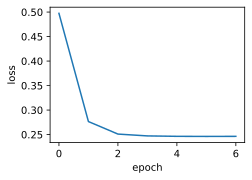

In [4]:
# 当批量大小为样本总数1,500时，优化使用的是梯度下降。
# 梯度下降的1个迭代周期对模型参数只迭代1次。可以看到6次迭代后目标函数值（训练损失）的下降趋向了平稳。
def train_sgd(lr, batch_size, num_epochs=2):
    train_ch7(sgd, None, {'lr': lr}, features, labels, batch_size, num_epochs)

train_sgd(1, 1500, 6)


当批量大小为1时，优化使用的是随机梯度下降。为了简化实现，有关（小批量）随机梯度下降的实验中，我们未对学习率进行自我衰减，而是直接采用较小的常数学习率。随机梯度下降中，每处理一个样本会更新一次自变量（模型参数），一个迭代周期里会对自变量进行1,500次更新。可以看到，目标函数值的下降在1个迭代周期后就变得较为平缓。

loss: 0.243772, 0.533764 sec per epoch


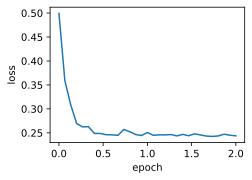

In [5]:
train_sgd(0.005, 1)

虽然随机梯度下降和梯度下降在一个迭代周期里都处理了1,500个样本，但实验中随机梯度下降的一个迭代周期耗时更多。这是因为随机梯度下降在一个迭代周期里做了更多次的自变量迭代，而且单样本的梯度计算难以有效利用矢量计算。

当批量大小为10时，优化使用的是小批量随机梯度下降。它在每个迭代周期的耗时介于梯度下降和随机梯度下降的耗时之间。

loss: 0.245205, 0.063920 sec per epoch


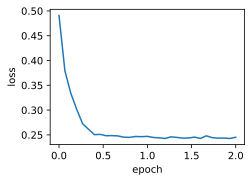

In [6]:
train_sgd(0.05, 10)

### 3.简洁实现
在PyTorch里可以通过创建optimizer实例来调用优化算法。这能让实现更简洁。下面实现一个通用的训练函数，它通过优化算法的函数optimizer_fn和超参数optimizer_hyperparams来创建optimizer实例。

In [21]:
def train_pytorch_ch7(optimizer_fn,optimizer_hyperparams,features,labels,batch_size=10,num_epochs=2):
    # 初始化模型
    net = nn.Sequential(
        nn.Linear(features.shape[-1],1)
    )
    loss = nn.MSELoss()
    optimizer = optimizer_fn(net.parameters(),**optimizer_hyperparams)

    def eval_loss():
        return loss(net(features).view(-1),labels).item()/2
    
    ls = [eval_loss()]
    data_iter = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(features,labels),batch_size,shuffle=True
    )

    for _ in range(num_epochs):
        start = time.time()
        for batch_i,(X,y) in enumerate(data_iter):
            # 除以2是为了和train_ch7里面保持一致，因为squared_loss中除了2
            l = loss(net(X).view(-1),y)/2

            optimizer.zero_grad()
            l.backward()
            optimizer.step()

            if(batch_i+1)*batch_size % 100 ==0:
                ls.append(eval_loss())
    
    print('loss: %f, %f sec per epoch' % (ls[-1], time.time() - start))
    d2l.set_figsize()
    d2l.plt.plot(np.linspace(0, num_epochs, len(ls)), ls)
    d2l.plt.xlabel('epoch')
    d2l.plt.ylabel('loss')


loss: 0.243557, 0.070209 sec per epoch


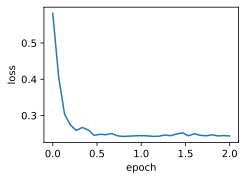

In [22]:
train_pytorch_ch7(optim.SGD, {"lr": 0.05}, features, labels, 10)

1. 小批量随机梯度每次随机均匀采样一个小批量的训练样本来计算梯度。
2. 在实际中，（小批量）随机梯度下降的学习率可以在迭代过程中自我衰减。
3. 通常，小批量随机梯度在每个迭代周期的耗时介于梯度下降和随机梯度下降的耗时之间。